In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time, sys
import random
import pickle
from tqdm import tqdm

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
rank = 28
mtype = "dgt_hodlr"


with open("../outputs/hpart_uni_gauss_allL.pickle", "rb") as f:
       hpart = pickle.load(f)

with open("../outputs/matrix_gauss_allL.pickle", "rb") as f:
       A = pickle.load(f)

m = A.shape[0]
n = A.shape[1]

A1 = mf.dgt_matrix(m, n, d=3, k=5)
print(f"{mf.rel_diff(A, A1)=}, {np.allclose(A, A1)=}")

symm = np.allclose(A, A.T) if m==n else False
if symm:
       print(f"MLR storage = {rank * m}")
else:
       print(f"MLR storage = {rank * (m + n)}")

mlr_storage = rank * (m + n)

mf.rel_diff(A, A1)=8.86306664555829e-18, np.allclose(A, A1)=True
MLR storage = 336000


In [4]:
np.linalg.norm(A1, ord='fro'), np.linalg.norm(A, ord='fro')

(656.8103904504331, 656.8103904504331)

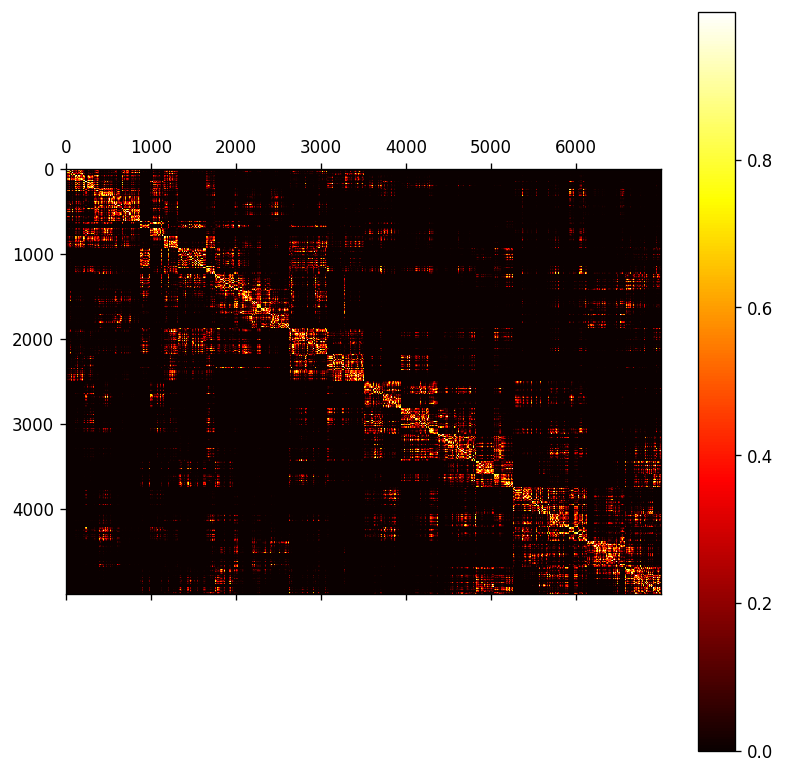

In [5]:
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
fig = plt.figure(figsize=(8, 8), dpi=120)
ax = fig.add_subplot(111)
cax = ax.matshow(perm_A, cmap='hot')
fig.colorbar(cax)
plt.show()

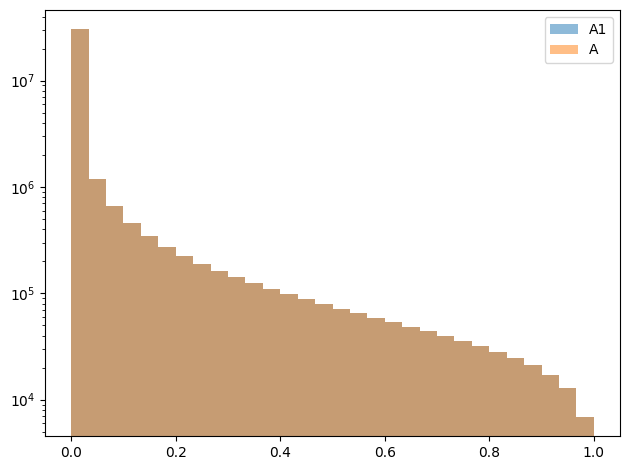

In [6]:
plt.hist(A1.flatten(), bins=30, alpha=0.5, label='A1')
plt.hist(A.flatten(), bins=30, alpha=0.5, label='A')
plt.legend(loc='upper right')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [7]:
print(np.histogram(A.reshape(-1), 7))

(array([32708583,  1023758,   527462,   326568,   212825,   135950,
          64854]), array([6.25666267e-31, 1.42851869e-01, 2.85703738e-01, 4.28555607e-01,
       5.71407476e-01, 7.14259345e-01, 8.57111214e-01, 9.99963082e-01]))


In [8]:
assert m == hpart['rows']['pi'].size and n == hpart['cols']['pi'].size
for level in range(len(hpart['rows']['lk'])):
    avg_rows = np.diff(np.array(hpart['rows']['lk'][level])).mean()
    avg_cols = np.diff(np.array(hpart['cols']['lk'][level])).mean()
    print(f"{level=}, {hpart['rows']['lk'][level].size-1}, {avg_rows=}, {avg_cols=}")

level=0, 1, avg_rows=5000.0, avg_cols=7000.0
level=1, 2, avg_rows=2500.0, avg_cols=3500.0
level=2, 4, avg_rows=1250.0, avg_cols=1750.0
level=3, 8, avg_rows=625.0, avg_cols=875.0
level=4, 16, avg_rows=312.5, avg_cols=437.5
level=5, 32, avg_rows=156.25, avg_cols=218.75
level=6, 64, avg_rows=78.125, avg_cols=109.375
level=7, 128, avg_rows=39.0625, avg_cols=54.6875
level=8, 256, avg_rows=19.53125, avg_cols=27.34375
level=9, 512, avg_rows=9.765625, avg_cols=13.671875
level=10, 1024, avg_rows=4.8828125, avg_cols=6.8359375
level=11, 2048, avg_rows=2.44140625, avg_cols=3.41796875
level=12, 4096, avg_rows=1.220703125, avg_cols=1.708984375
level=13, 5000, avg_rows=1.0, avg_cols=1.4


In [9]:
rel_tol = 0.05625
tol = rel_tol * np.linalg.norm(A, ord='fro')
tol

36.94558446283686

In [10]:
A_HODLR, A_HODLR_fillin, bl_sizes, count = mf.build_hodlr(hpart, m, n, A, tol)

100%|██████████| 14/14 [00:43<00:00,  3.14s/it]


In [11]:
np.histogram(A_HODLR_fillin.reshape(-1), bins=5)

(array([       0,        0, 35000000,        0,        0]),
 array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]))

In [12]:
# assert (A_HODLR == 0).sum() == 0, print((A_HODLR == 0).sum())

In [13]:
hodlr_storage = mf.get_hodlr_storage(bl_sizes, count, m, n)

In [14]:
np.histogram(bl_sizes[:, 0])

(array([14976,    11,     4,     1,     2,     0,     0,     2,     0,
            2]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]))

In [15]:
(bl_sizes[:, 0]==0).sum(), (bl_sizes[:, 0]==1).sum(),  (bl_sizes[:, 0]==2).sum()

(9939, 5037, 11)

In [16]:
print(f"{rel_tol=},   err={mf.rel_diff(A_HODLR, den=A)},   {hodlr_storage=}")
# rel_tol=0.1,     err=0.8732317517163809,     hodlr_storage=163750 
# rel_tol=0.075,   err=0.8033487742710682,     hodlr_storage=244378
# rel_tol=0.05625,   err=0.7254858753535808,   hodlr_storage=338503
# rel_tol=0.0625,   err=0.7489995846411727,    hodlr_storage=305875
# rel_tol=0.05,   err=0.6842065437527491,      hodlr_storage=394561
# rel_tol=0.01,    err=0.3206812209970444,     hodlr_storage=1360560
# rel_tol=0.001,   err=0.047308271276605904,   hodlr_storage=3608840
# rel_tol=0.0005,  err=0.020940621463998457,   hodlr_storage=4461538

rel_tol=0.05625,   err=0.7254858753535808,   hodlr_storage=338503


In [17]:
(0.0625+0.05)/2

0.05625

In [18]:
print(f"{hodlr_storage=}")
print(f"  {mlr_storage=}")
print(f"       {m * n =}")
print(f"{m*n - hodlr_storage=}")
mlr_storage * 1./ hodlr_storage

hodlr_storage=338503
  mlr_storage=336000
       m * n =35000000
m*n - hodlr_storage=34661497


0.9926056785316526

In [19]:
# LR             0.4177886748298519
# LR+D           0.4274107034651386
# RA uniform     0.2176561255268253
# RA bottom      0.1675317813793931
# RA top         0.2575911845483002

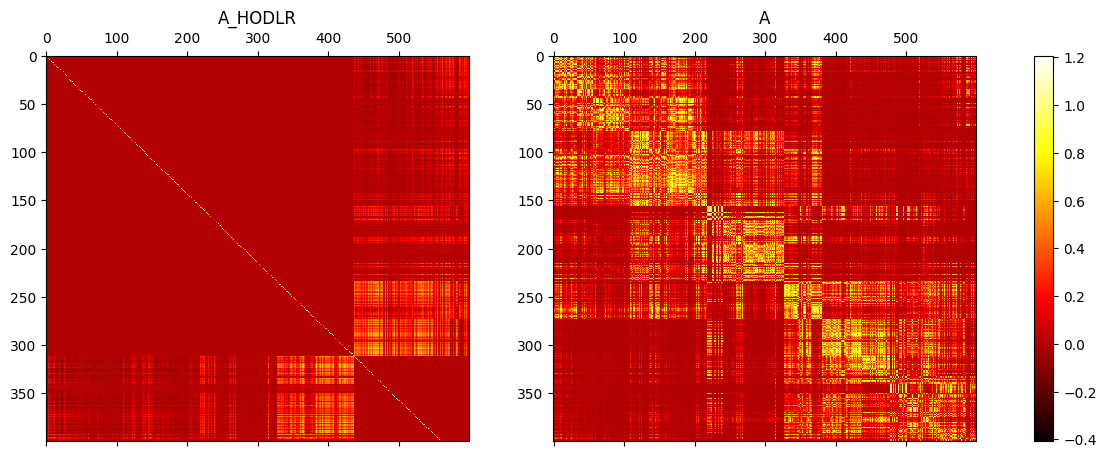

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
vmin = min(A.min(), A_HODLR.min())
vmax = max(A.max(), A_HODLR.max())
perm_A_HODLR = A_HODLR[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax1 = axs[0].matshow(perm_A_HODLR[:400,:600], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('A_HODLR')
perm_A = A[hpart['rows']['pi'], :][:, hpart['cols']['pi']]
cax2 = axs[1].matshow(perm_A[:400, :600], cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('A')

fig.colorbar(cax1, ax=axs, orientation='vertical')
plt.show()

In [21]:
a_diags = []
for level in [-1, -2, -3]:
    num_blocks = len(hpart['rows']['lk'][level]) - 1
    a_diags += [np.zeros((m, n))]
    for i, block in enumerate(range(num_blocks)):
        r1, r2 = hpart['rows']['lk'][level][block], hpart['rows']['lk'][level][block+1]
        c1, c2 = hpart['cols']['lk'][level][block], hpart['cols']['lk'][level][block+1]
        a_diags[-1][r1:r2, c1:c2] = 2*np.ones((r2-r1, c2-c1))

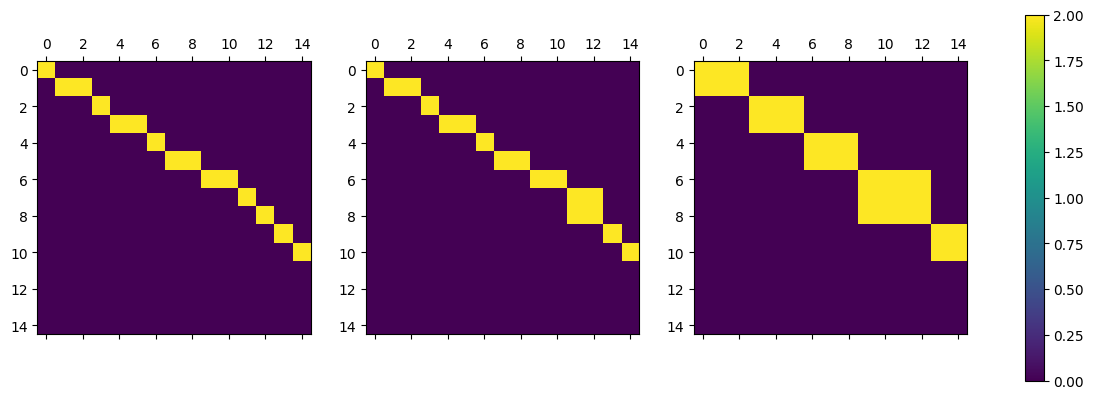

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
max_el = 15
cax1 = axs[0].matshow(a_diags[0][:max_el, :max_el], cmap='viridis')
cax2 = axs[1].matshow(a_diags[1][:max_el, :max_el], cmap='viridis')
cax3 = axs[2].matshow(a_diags[2][:max_el, :max_el], cmap='viridis')

cbar = fig.colorbar(cax2, ax=axs.ravel().tolist(), shrink=0.95)
plt.show()